### Port-Hamiltonian Optimizer
Copyright (c) 2020. Daniel Albert. Published under the GNU General Public License.

This notebook will explore the feasibility of learning a linear boundary with the Port-Hamiltonian based optimizer.
The distribution is created and seeded with the same parameters as the one by Massaroli et al., such that we may directly compare the results obtained.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split

from PHNetworks.PHOptimizer import PortHamiltonianOptimizer as PHOpt, _model_set_flat_variables

Create some test data

In [3]:
N = 1000

np.random.seed(1)
X1 = np.random.multivariate_normal([0.6, 0.7], [[0.025, 0.0], [0.0, 0.01]], N)
Y1 = np.hstack((np.ones((N, 1)), np.zeros((N, 1))))

np.random.seed(2)
X2 = np.random.multivariate_normal([0.1, 0.2], [[0.025, -0.00], [-0.00, 0.01]], N)
Y2 = np.hstack((np.zeros((N, 1)), np.ones((N, 1))))

X = np.vstack((X1,X2))
Y = np.vstack((Y1,Y2))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

x_range = (X_train.min(0)[0], X_train.max(0)[0])
y_range = (X_train.min(0)[1], X_train.max(0)[1])

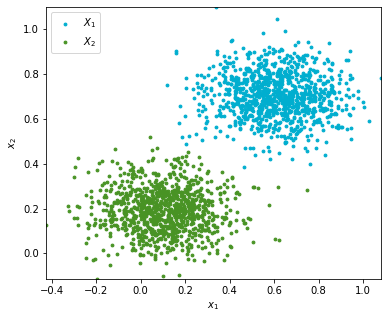

In [4]:
plt.figure(figsize=(6,5))

plt.scatter(X1[:,0],X1[:,1],label='$X_1$', rasterized=False, s=8, c='#00aecf')
plt.scatter(X2[:,0],X2[:,1],label='$X_2$', rasterized=False, s=8, c='#489324')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(x_range)
plt.ylim(y_range)
plt.legend();

plt.savefig('training_data.pdf')

Construct a tiny, linear network with two inputs. The network structure and loss function are the same as in the paper.

In [5]:
def get_model():
    # The model consists of just two input neurons and two linear output neurons
    model = keras.models.Sequential(layers=[
        keras.layers.Dense(2, input_shape=(2,), name='input_layer', dtype='float64')
    ])

    # The loss function is the sum of squared differences
    @tf.function
    def loss(y_pred, y_true):
        return tf.math.reduce_sum(tf.math.square(y_pred - y_true))

    model.compile(loss=loss)
    
    # Print summary
    model.summary()
    
    # Initialize the model with the same parameters as the original paper did
    _model_set_flat_variables(model, tf.constant([0.6, -2.3, -0.1, -1.1, -1.2, 0.3], dtype='float64'))
    
    return model

In [6]:
model = get_model()
optimizer = PHOpt(alpha=1.0, beta=0.1, gamma=1.1, resistive=0.5, ivp_period=20, ivp_step_size=0.025)

# The following is not intended usage, but lets us reproduce the starting conditions as given in the paper exactly:
optimizer._check_model_and_state(model)
optimizer._integrator.velocity.assign(tf.constant([-1.2, 0.3, 0.2, 1.6, -0.4, 1.6], shape=(6,1), dtype='float64'))

with tf.device('/gpu:0'):
    optimizer.train(model, X_train, Y_train, batch_size=500, metrics=[keras.metrics.CategoricalAccuracy()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
3/3 [==============================] - 2s 508ms/step - loss: 24.6512 - energy: 12.6065 - categorical_accuracy: 0.9983


Okay, the training's done.

From the output above, we see that the single training epoch took 2 seconds.

Let's plot the points in the _testing_ dataset and find out whether they are classified correctly.

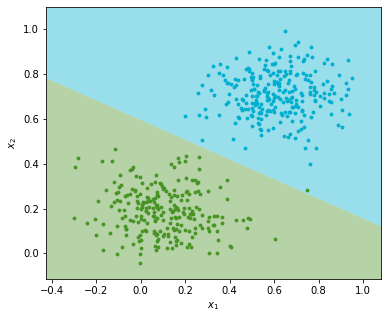

In [7]:
num_p = 100

u1 = np.linspace(*x_range, num_p)
u2 = np.linspace(*y_range, num_p)

U1, U2 = np.meshgrid(u1, u2)
Z = np.zeros((num_p, num_p))

# Formula for the border of the two zones. Hand-derived from the equations for the output neuron's activations
# This is used to color the two zones in the model
def f(x):
    w = model.weights[0]
    b = model.weights[1]
    return ((w[0,1] - w[0,0]) * x + b[1] - b[0]) / (w[1,0] - w[1,1])


plt.figure(figsize=(6,5))

split = f(u1)

plt.fill_between(u1, y_range[0], split, color='#489324', alpha=0.4, lw=0)
plt.fill_between(u1, split, y_range[1], color='#00aecf', alpha=0.4, lw=0)

X1_test = X_test[Y_test[:,0] >= Y_test[:,1]]
X2_test = X_test[Y_test[:,0] <  Y_test[:,1]]

Y_test_m = model(X_test)

plt.scatter(X1_test[:,0], X1_test[:,1], label='$X_1$', rasterized=False, s=8, c='#00aecf')
plt.scatter(X2_test[:,0], X2_test[:,1], label='$X_2$', rasterized=False, s=8, c='#489324')

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(x_range)
plt.ylim(y_range);

plt.savefig('trained_boundary.pdf')

In the graphic it seems that all points of the test set were classified correctly.
To validate this:

In [8]:
ca = tf.keras.metrics.CategoricalAccuracy()
ca.update_state(Y_test, Y_test_m)
ca.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.998>

Thus, 100 % of the points in our test set have been categorized correctly.

Now, looking at the whole dataset, the combined training and testing datasets:

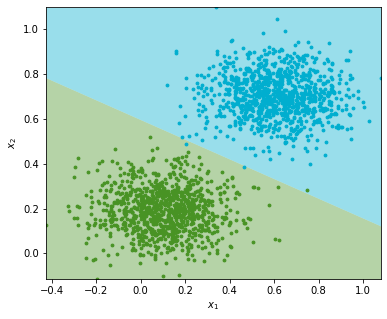

In [9]:
plt.figure(figsize=(6,5))

split = f(u1)

plt.fill_between(u1, y_range[0], split, color='#489324', alpha=0.4, lw=0)
plt.fill_between(u1, split, y_range[1], color='#00aecf', alpha=0.4, lw=0)

X1_test = X_test[Y_test[:,0] >= Y_test[:,1]]
X2_test = X_test[Y_test[:,0] <  Y_test[:,1]]

Y_m = model(X)

plt.scatter(X1[:,0], X1[:,1], label='$X_1$', rasterized=False, s=8, c='#00aecf')
plt.scatter(X2[:,0], X2[:,1], label='$X_2$', rasterized=False, s=8, c='#489324')

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(x_range)
plt.ylim(y_range);

It seems that only two (of 2000) points being categorized incorrectly.
Validating this:

In [10]:
ca.reset_states()
ca.update_state(Y, Y_m)
ca.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9985>

So we have obtained a classification accuracy of 99.9 %.

